<a href="https://colab.research.google.com/github/keinerfan/CIAP_ANN/blob/main/ann_MLP_regression_test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Load the dataset
data = pd.read_csv("CIAP1_and_CIAP2_06_bioactivity_data_3class_pIC50_pubchem_fp.csv")

# Feature selection using VarianceThreshold
from sklearn.decomposition import PCA
pca = PCA(n_components=104)
X_pca= pca.fit_transform(data.drop(['pIC50'] , axis =1 ))


# Prepare X and y
x = X_pca
y = data.pIC50.values.reshape((-1,1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalize y using StandardScaler
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# Convert data to PyTorch tensors
device = torch.device("cpu")
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()

# Create DataLoader for training
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)


# **model from qsar lesson**

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)
        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc_out(out)
        return out

# Define hyperparameters
input_size = 104
hidden_size = 1024
dropout_rate = 0.80
output_size = 1
learning_rate = 0.001


In [ ]:
# Initialize model, criterion, and optimizer
model = Net(input_size, hidden_size, dropout_rate, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
model.train()
epochs = 200
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        optimizer.zero_grad()
        output = model(fps)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        if e % 10 == 0:
            print(f"Epoch: {e:3d} Training loss: {running_loss / len(train_loader):.2f}")

# Evaluation on test set
model.eval()
y_pred_test = model(X_test)
r2_test = r2_score(y_test.detach().numpy(), y_pred_test.detach().numpy())

print(f"R^2 score on test set: {r2_test:.2f}")


Epoch:   0 Training loss: 1.59
Epoch:  10 Training loss: 0.52
Epoch:  20 Training loss: 0.41
Epoch:  30 Training loss: 0.37
Epoch:  40 Training loss: 0.32
Epoch:  50 Training loss: 0.30
Epoch:  60 Training loss: 0.27
Epoch:  70 Training loss: 0.25
Epoch:  80 Training loss: 0.24
Epoch:  90 Training loss: 0.22
Epoch: 100 Training loss: 0.20
Epoch: 110 Training loss: 0.21
Epoch: 120 Training loss: 0.20
Epoch: 130 Training loss: 0.21
Epoch: 140 Training loss: 0.17
Epoch: 150 Training loss: 0.16
Epoch: 160 Training loss: 0.18
Epoch: 170 Training loss: 0.17
Epoch: 180 Training loss: 0.17
Epoch: 190 Training loss: 0.16
R^2 score on test set: 0.58


# **another model**

In [ ]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(104, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [ ]:
 mlp = MLP()

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

In [ ]:
epochs =1500
losses = []
for i in range (epochs) :
  #go forward
  y_pred = mlp.forward(X_train)
  #measure loss
  loss =  loss_function(y_pred , y_train)
  losses.append(loss.detach().numpy())
  if i % 100 == 0 :
    print(f'epoch:{i} and loss : {loss}')
  #back propagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


epoch:0 and loss : 1.0470212697982788
epoch:100 and loss : 0.8924649357795715
epoch:200 and loss : 0.6754068732261658
epoch:300 and loss : 0.45154502987861633
epoch:400 and loss : 0.3164221942424774
epoch:500 and loss : 0.25719645619392395
epoch:600 and loss : 0.22310930490493774
epoch:700 and loss : 0.195441335439682
epoch:800 and loss : 0.17173230648040771
epoch:900 and loss : 0.1508828103542328
epoch:1000 and loss : 0.13257895410060883
epoch:1100 and loss : 0.11698385328054428
epoch:1200 and loss : 0.10378323495388031
epoch:1300 and loss : 0.09265144169330597
epoch:1400 and loss : 0.08353286236524582


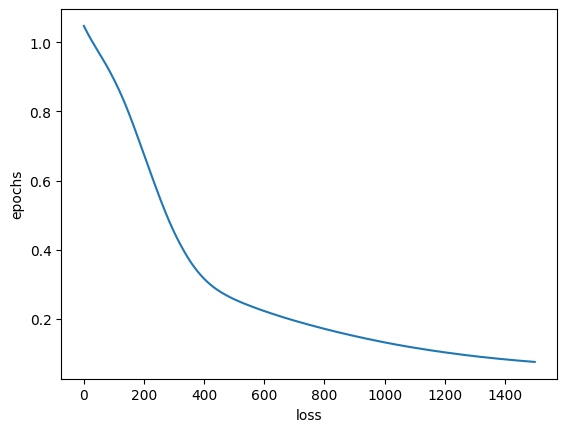

In [ ]:
plt.plot(range(epochs) , losses)
plt.xlabel("loss")
plt.ylabel("epochs")
plt.show()

In [ ]:
y_pred_test = mlp(X_test)
r2_test = r2_score(y_test.detach().numpy(), y_pred_test.detach().numpy())

print(f"R^2 score on test set: {r2_test:.2f}")


R^2 score on test set: 0.50
